#### Adapted from /global/cfs/cdirs/lz/users/rcoronel/Analysis/MiXDAQDevelopment/LEDCalibration/RelativeGains.ipynb

## Imports

In [1]:
%%time

import numpy as np
from numpy import random
from numpy.matlib import repmat
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy
import uproot
import awkward as ak
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import glob
import os
import importlib
import sys
sys.path.append('..')
import MiXHelper
import csv
from prettytable import PrettyTable

ts = 25
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': ts,
          'axes.titlesize': ts,
          'xtick.labelsize': ts,
          'ytick.labelsize': ts}
plt.rcParams.update(params)

CPU times: user 940 ms, sys: 236 ms, total: 1.18 s
Wall time: 8.07 s


In [2]:
importlib.reload(MiXHelper)

<module 'MiXHelper' from '/home/samaraa/MiXHelper.py'>

## Analysis

In [3]:
%%time

##sort the data files. the names differ by time stamps so now they're in chronological order
filePath = '/home/samaraa/Data/20230118/'
#ignore the bPMT data from 01/18
fileNames = sorted(filter(os.path.isfile, glob.glob(filePath + '*.root')))[:-30]

bFilePath = '/home/samaraa/Data/20230123/'
bFileNames = sorted(filter(os.path.isfile, glob.glob(bFilePath + '*.root')))

fileNames += bFileNames

CPU times: user 1.53 ms, sys: 1.15 ms, total: 2.67 ms
Wall time: 66 ms


In the original relative gains calibration, we only took data for one PMT at a time. This time, we set all the tPMTs to the same voltage and bPMT to zero. We started with tPMTs at 850V and went down to 650V in 50V increments. We took 15 files at each configuration.

Then we set all tPMT to zero and biased the bPMT from 1200V to 1700V in 100V increments. 5 files per configuration since 15 seems like a lot

In [4]:
%%time

##Found by looking at the data folder names on abacus. in the order we took the data
voltageTop = [650, 700, 750, 800, 850]
voltageBottom = [1200, 1300, 1400, 1500, 1600, 1700]

#15 for the tPMT runs, 5 for the bPMT
numFilesPerRun = [15, 15, 15, 15, 15, 5, 5, 5, 5, 5, 5]

#where "in range(#)" is the number of runs for that PMT
pulseAreaAll = []
for i in range(4):
        pulseAreaAll.append([[] for i in range(5)])

#now append the bottom one too, separately since 6 runs
pulseAreaAll.append([[] for i in range(6)])

"""
#previous way
pulseArea0 = [[] for i in range(5)]
pulseArea1 = [[] for i in range(5)]
pulseArea2 = [[] for i in range(5)]
pulseArea3 = [[] for i in range(5)]
pulseArea4 = [[] for i in range(6)]
pulseAreaAll = [pulseArea0, pulseArea1, pulseArea2, pulseArea3, pulseArea4]
"""

CPU times: user 13 µs, sys: 4 µs, total: 17 µs
Wall time: 19.8 µs


'\n#previous way\npulseArea0 = [[] for i in range(5)]\npulseArea1 = [[] for i in range(5)]\npulseArea2 = [[] for i in range(5)]\npulseArea3 = [[] for i in range(5)]\npulseArea4 = [[] for i in range(6)]\npulseAreaAll = [pulseArea0, pulseArea1, pulseArea2, pulseArea3, pulseArea4]\n'

In [5]:
len(fileNames), sum(numFilesPerRun)

(105, 105)

In [6]:
%%time

numFilesDone = 0
start = 1490

#Note len(numFilesPerRun) is just the number of runs
for run in range(len(numFilesPerRun)):
    ##Find the pulse areas for each channel for each event
    if run < 5:
        #then this is a tPMT run
        cutoff = 1505
        for channel in range(4):
            tempArea = []
            pulseAreaAll[channel][run] = MiXHelper.PMTPulseArea(fileNames[numFilesDone:numFilesDone+numFilesPerRun[run]],
                                   channel, start, cutoff, tempArea)
            print(run, channel)
        numFilesDone += numFilesPerRun[run]
    else:
        channel = 4
        #The bPMT signals are a little later than the tPMT ones -> use later cutoff
        cutoff = 1510
        tempArea = []
        pulseAreaAll[channel][run - 5] = MiXHelper.PMTPulseArea(fileNames[numFilesDone:numFilesDone+numFilesPerRun[run]],
                                   channel, start, cutoff, tempArea)
        print(run, channel)
        numFilesDone += numFilesPerRun[run]

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 4
6 4
7 4
8 4
9 4
10 4
CPU times: user 19min 33s, sys: 2min 26s, total: 22min
Wall time: 25min 45s


In [7]:
%%time

#5 PMTs
averagePulseAreaAll = [[] for i in range(5)]
stdevPulseAreaAll = [[] for i in range(5)]

#each PMT has at least 5 runs
for run in range(5):
    for channel in range(5):
        averagePulseAreaAll[channel].append(np.average(pulseAreaAll[channel][run]))
        stdevPulseAreaAll[channel].append(np.std(pulseAreaAll[channel][run]))
        
#then do bPMT's sixth run
averagePulseAreaAll[4].append(np.average(pulseAreaAll[4][5]))
stdevPulseAreaAll[4].append(np.std(pulseAreaAll[4][5]))

CPU times: user 273 ms, sys: 1.85 ms, total: 275 ms
Wall time: 280 ms


In [8]:
def plot(x, voltage, y, correction, label):
    fit = np.polyfit(voltage, y, 1)
    line = fit[0]*x + fit[1] + correction
    plt.scatter(voltage, y + correction, label=label)
    plt.plot(x, line, label='slope = '+format(fit[0],'.2f'))

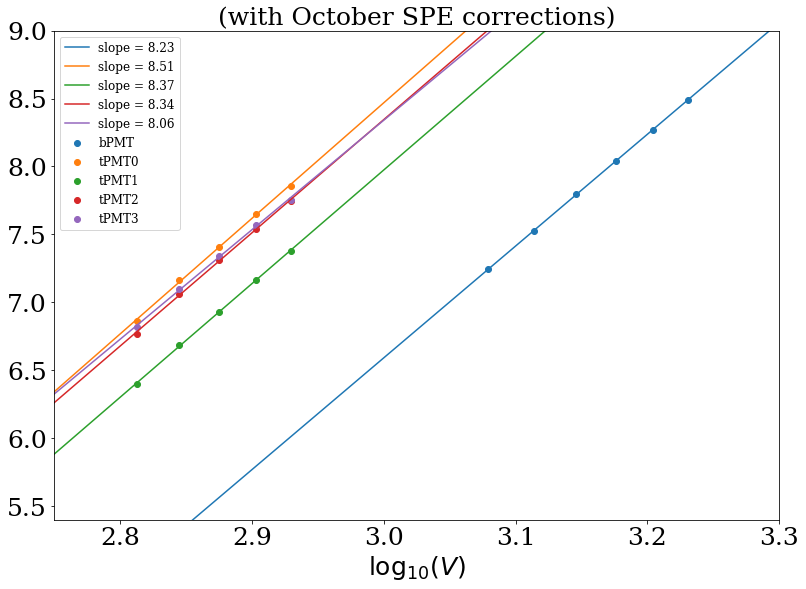

In [9]:
x = np.linspace(2.7, 3.3, 100)
#october SPE corrections
SPE = [7.25e6,2.5e6,5.9e6,6.6e6,1.75e7]

#bPMT first here even though it's last everywhere else so the colors match the previous plot
plot(x, np.log10(voltageBottom), np.log10(averagePulseAreaAll[4]),
     np.log10(SPE[4]/averagePulseAreaAll[4][0]), 'bPMT')
plot(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[0]),
     np.log10(SPE[0]/averagePulseAreaAll[0][0]), 'tPMT0')
plot(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[1]),
     np.log10(SPE[1]/averagePulseAreaAll[1][0]), 'tPMT1')
plot(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[2]),
     np.log10(SPE[2]/averagePulseAreaAll[2][0]), 'tPMT2')
plot(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[3]),
     np.log10(SPE[3]/averagePulseAreaAll[3][0]), 'tPMT3')

plt.xlim([2.75, 3.3])
plt.ylim([5.4,9])
plt.legend()
plt.xlabel('$\log_{10}(V)$')
plt.title('(with October SPE corrections)')
plt.show()

In [12]:
originalSlopes = np.array([8.69, 8.43, 8.49, 8.65, 7.63])
octSlopes = np.array([8.48, 8.31, 8.34, 8.48, 8.06])
janSlopes = np.array([8.51, 8.37, 8.34, 8.06, 8.23])
percentChange = np.around(100 * (octSlopes - janSlopes)/octSlopes, 3)
percentChange

array([-0.354, -0.722,  0.   ,  4.953, -2.109])

In [14]:
table = PrettyTable()
table.add_column('PMT', ['t0', 't1', 't2', 't3', 'b4'])
table.add_column('June', originalSlopes)
table.add_column('October', [8.48, 8.31, 8.34, 8.48, 8.06])
table.add_column('January', janSlopes)
table.add_column('% Change Oct-Jan', percentChange)
print(table)

+-----+------+---------+---------+------------------+
| PMT | June | October | January | % Change Oct-Jan |
+-----+------+---------+---------+------------------+
|  t0 | 8.69 |   8.48  |   8.51  |      -0.354      |
|  t1 | 8.43 |   8.31  |   8.37  |      -0.722      |
|  t2 | 8.49 |   8.34  |   8.34  |       0.0        |
|  t3 | 8.65 |   8.48  |   8.06  |      4.953       |
|  b4 | 7.63 |   8.06  |   8.23  |      -2.109      |
+-----+------+---------+---------+------------------+


---
making gain params file

In [15]:
def fit(x, voltage, y, correction):
    fit = np.polyfit(voltage, y, 1)
    return fit

SPE = [7.25e6,2.5e6,5.9e6,6.6e6,1.75e7] #october 2022

bPMT_correction = np.log10(SPE[4]/averagePulseAreaAll[4][0])
bPMT_fit = fit(x, np.log10(voltageBottom), np.log10(averagePulseAreaAll[4]), bPMT_correction)

tPMT0_correction = np.log10(SPE[0]/averagePulseAreaAll[0][0])
tPMT0_fit = fit(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[0]), tPMT0_correction)

tPMT1_correction = np.log10(SPE[1]/averagePulseAreaAll[1][0])
tPMT1_fit = fit(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[1]), tPMT1_correction)

tPMT2_correction = np.log10(SPE[2]/averagePulseAreaAll[2][0])
tPMT2_fit = fit(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[2]), tPMT2_correction)

tPMT3_correction = np.log10(SPE[3]/averagePulseAreaAll[3][0])
tPMT3_fit = fit(x, np.log10(voltageTop), np.log10(averagePulseAreaAll[3]), tPMT3_correction)

In [16]:
%%time

fields = ['p', 'logA', 'correction']
rows = [[tPMT0_fit[0], tPMT0_fit[1], tPMT0_correction],
        [tPMT1_fit[0], tPMT1_fit[1], tPMT1_correction],
        [tPMT2_fit[0], tPMT2_fit[1], tPMT2_correction],
        [tPMT3_fit[0], tPMT3_fit[1], tPMT3_correction],
        [bPMT_fit[0], bPMT_fit[1], bPMT_correction]]

filename = 'gainparams20230123.csv'

with open(filename, 'w') as csvfile:
    
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

CPU times: user 996 µs, sys: 0 ns, total: 996 µs
Wall time: 2.98 ms
